# Time-series analysis
© 2024 Exneyder A. Montoya-Araque, Silvana Montoya-Noguera and Universidad EAFIT.

This notebook can be interactively run in [Google - Colab](https://colab.research.google.com/github/AppliedMechanics-EAFIT/soil_dynamics/blob/main/notebooks/time_series_analysis.ipynb).

<!-- The content of this notebook was developed based on [L. Zeevaert (1973)](<https://doi.org/10.1016/0148-9062(76)91911-2>). -->

## Required modules and global setup for plots

In [1]:
# Standard libraries
import os
import sys
import itertools
import re
import subprocess
# Scientific computing libraries
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib as mpl
# Seismology libraries
# import obspy
# from obspy.signal import tf_misfit
# import smtk.response_spectrum as rsp # Response Spectra tools
# Widgets and other libraries
from ipywidgets import widgets as wgt
from IPython import get_ipython

if 'google.colab' in str(get_ipython()):
    print('Running on CoLab. Installing the required modules...')
    subprocess.run('pip install ipympl', shell=True);
    subprocess.run('pip install PySeismoSoil', shell=True);
    from google.colab import output, files
    output.enable_custom_widget_manager()
else:
    import tkinter as tk
    from tkinter.filedialog import askopenfilename

from PySeismoSoil.class_ground_motion import Ground_Motion
from PySeismoSoil import helper_signal_processing as sig
from PySeismoSoil import helper_site_response as sr

%matplotlib widget

# plt.style.use("default")
mpl.rcParams.update(
    {
        'figure.constrained_layout.use': True,
        'interactive': False,
        "text.usetex": False,  # Use mathtext, not LaTeX
        "font.family": "cmr10",  # Use the Computer modern font
        "mathtext.fontset": "cm",
        "axes.formatter.use_mathtext": True,
        "axes.unicode_minus": False,
    }
)

In [2]:
# Create a folder called TRIGRS in the current working directory if it doesn't exist
workdir = os.getcwd()
records_dir = os.path.join(workdir, "records")
os.makedirs(f"{records_dir}", exist_ok=True)

## Functions to read instrumental data

In [3]:
def read_peer(file_name):
    # Determine the file name and conversion factor based on extension
    ext = file_name.split('.')[-1]
    if ext == 'AT2':
        fc = 9.80665
    elif ext in ['VT2', 'DT2']:
        fc = 1  # v in cm/s, d in cm
    # Read the file to extract the 'NPTS' and 'DT' values
    with open(file_name, 'r') as file:
        line = file.readlines()[3]
        parts = line.split(',')
        npts = int(parts[0].split('=')[1].strip())
        dt = float(parts[1].split('=')[1].split()[0].strip())
    # Read time-series data
    raw_data = np.loadtxt(file_name, skiprows=4)
    series = np.reshape(raw_data, -1) * fc
    time = np.arange(0, len(series) * dt, dt)
    return time, series


def read_jp(file_name):
    with open(file_name, 'r') as file:
        lines = file.readlines()
        # Read sampling frequency
        df_line = lines[10]
        df_str = df_line.split()[2]
        df = float(df_str.replace('Hz', ''))
        # Read scale factor
        sf_line = lines[13]
        sf_str = sf_line.split()[-1]
        sf_parts = sf_str.split('/')
        sf_num = float(sf_parts[0].replace('(gal)', ''))
        sf_den = float(sf_parts[1])
    # Read time-series data
    raw_data = np.loadtxt(file_name, skiprows=17)
    series = np.reshape(raw_data, -1)
    of = np.mean(series)
    series = (series - of) * sf_num / sf_den * 0.01  # corrected scaled a in m/s2
    dt = 1 / df
    time = np.arange(0, len(series) * dt, dt)
    return time, series


def read_cyt(file_name):
    with open(file_name, 'r') as file:
        # Read initial values
        lines = file.readlines()
        line_str = lines[2].split()
        tocy, dtcy, nucy, _ = float(line_str[0]), float(line_str[1]), int(line_str[2]), int(line_str[3])
    # Rewrite the file to fix the format
    with open(file_name, 'w') as file:
        for i in range(3, len(lines)):
            # lines[i] = re.findall(r'-?\d+\.\d+|-?\d+', lines[i])
            lines[i] = re.sub(r'(-)', r' \1', lines[i])
        # write the lines back to the file
        file.writelines(lines)
    # Read time-series data
    raw_data = np.loadtxt(file_name, skiprows=3)
    series = np.reshape(raw_data, -1) 
    time = np.arange(0, len(series) * dtcy, dtcy)
    return time, series

def read_sgc(file_name):
    # Read dt
    with open(file_name, 'r') as file:
        dt_line = file.readlines()[11]
        dt = float(dt_line.split()[-1])
    # Read time-series data
    raw_data = np.loadtxt(file_name, skiprows=20) * 0.01  # convert to m/s2
    series_ew = raw_data[:, 0]
    series_ns = raw_data[:, 2]
    series_ud = raw_data[:, 1]
    time = np.linspace(0, len(series_ew) * dt, len(series_ew))
    return time, (series_ew, series_ns, series_ud)

def read_siata(file_name):
    # Read dt
    with open(file_name, 'r') as file:
        dt_line = file.readlines()[21]
        dt = float(dt_line.split()[-1])
    # Read time-series data
    raw_data = np.loadtxt(file_name, skiprows=28, delimiter=',') * 0.01  # convert to m/s2
    series_ew = raw_data[:, 0]
    series_ns = raw_data[:, 1]
    series_ud = raw_data[:, 2]
    time = np.linspace(0, len(series_ew) * dt, len(series_ew))
    return time, (series_ew, series_ns, series_ud)


def load_file(source='peer'):
    '''
    source : str
        The source of the file. Options are 'peer', 'jp', 'cyt', 'sgc', and 'siata'.
    '''
    if 'google.colab' in str(get_ipython()):
        file = files.upload()
        # Move the file to the records folder
        os.rename(list(file.keys())[0], os.path.join(records_dir, list(file.keys())[0]))
        file_name = os.path.join(records_dir, list(file.keys())[0])
    else:
        tk.Tk().withdraw() # part of the import if you are not using other tkinter functions
        file = askopenfilename()
        # Move the file to the records folder
        os.rename(file, os.path.join(records_dir, os.path.basename(file)))
        file_name = os.path.join(records_dir, os.path.basename(file))
    if source == 'peer':
        time, series = read_peer(file_name)
    elif source == 'jp':
        time, series = read_jp(file_name)
    elif source == 'cyt':
        time, series = read_cyt(file_name)
    elif source == 'sgc':
        time, series = read_sgc(file_name)
    elif source == 'siata':
        time, series = read_siata(file_name)
    return time, series

## Plotting functions

In [4]:
cols = ["#004488", "#DDAA33", "#BB5566"]

def plot_time_series(gm):
    fig, axs = plt.subplots(3, 1, figsize=(6, 5), sharex=True, layout='constrained')
    # Acceleration
    t, a = np.transpose(gm.accel)
    pga = np.max(np.abs(a))
    pga_index = np.argmax(np.abs(a))
    axs[0].plot(t, a, label='Acceleration', c=cols[0])
    axs[0].plot(t[pga_index], a[pga_index], c='k', marker='o', markersize=7, fillstyle='none')
    axs[0].text(t[pga_index], a[pga_index], f'  PGA = {pga:.2f} m/s$^2$', fontsize=12,
                va='center_baseline', ha='left')
    axs[0].set_ylabel('Acceleration  [m/s$^2$]')
    # Velocity
    t, v = np.transpose(gm.veloc)
    axs[1].plot(t, v, label='Velocity', c=cols[1])
    axs[1].set_ylabel('Velocity  [m/s]')
    # Displacement
    t, d = np.transpose(gm.displ)
    axs[2].plot(t, d, label='Displacement', c=cols[2])
    axs[2].set_ylabel('Displacement  [m]')
    axs[2].set_xlabel('Time  [s]')
    # Format the plot
    for ax in axs:
        ax.grid(True, which='both', ls='--')
        # make y axis symmetrical
        abs_y_max = 1.2*max(np.abs(ax.get_ylim()))
        ax.set_ylim(-abs_y_max, abs_y_max)        
    fig.canvas.header_visible = False
    fig.canvas.toolbar_position = 'bottom'
    plt.show()
    return fig

def plot_arias_int(gm):
    fig, axs = plt.subplots(2, 1, figsize=(6, 4), sharex=True, layout='constrained')
    # Arias Intensity
    t, ai = np.transpose(gm.Arias_Intensity)
    _, ai_norm = np.transpose(gm.Arias_Intensity_normalized)
    d5_idx = np.argwhere(ai_norm >= 0.05)[0, 0]
    d95_idx = np.argwhere(ai_norm >= 0.95)[0, 0]
    d5, d95 = t[d5_idx], t[d95_idx]
    axs[0].plot(t, ai, label='Arias Intensity', c=cols[2])
    axs[0].set_ylabel('Arias Intensity  [m/s]')
    # Acceleration
    t, a = np.transpose(gm.accel)
    axs[1].plot(t, a, label='Acceleration', c=cols[0])
    axs[1].set_ylabel('Acceleration  [m/s$^2$]')
    abs_y_max = 1.2*max(np.abs(axs[1].get_ylim()))
    axs[1].set_ylim(-abs_y_max, abs_y_max)
    axs[1].set_xlabel('Time  [s]')
    # Format the plot
    for ax in axs:
        ax.grid(True, which='both', ls='--')
        ax.axvspan(d5, d95, alpha=0.30, color=cols[1], label=f'Significant duration: {d95-d5:.2f} s')
    handles, labels = axs[0].get_legend_handles_labels()
    # append acceleration handle to the legend
    handles.insert(1, axs[1].get_legend_handles_labels()[0][0])
    labels.insert(1, axs[1].get_legend_handles_labels()[1][0])
    axs[0].legend(handles, labels, loc='best')
    fig.canvas.header_visible = False
    fig.canvas.toolbar_position = 'bottom'
    plt.show()
    
def plot_spectra(gm, xlog=True, ylog=True, T_min=0.01, T_max=10, damping=0.05):
    fig, axs = plt.subplots(3, 1, figsize=(6, 6), layout='constrained') 
    # Acceleration
    t, a = np.transpose(gm.accel)
    pga = np.max(np.abs(a))
    pga_index = np.argmax(np.abs(a))
    axs[0].plot(t, a, label='Acceleration', c=cols[0])
    axs[0].plot(t[pga_index], a[pga_index], c='k', marker='o', markersize=7, fillstyle='none')
    axs[0].text(t[pga_index], a[pga_index], f'  PGA = {pga:.2f} m/s$^2$', fontsize=12,
                va='center_baseline', ha='left')
    axs[0].set(ylabel='Acceleration  [m/s$^2$]', xlabel='Time  [s]', title='Acceleration-Time History')
    abs_y_max = max(np.abs(axs[0].get_ylim()))
    axs[0].set_ylim(-1.1*abs_y_max, 1.1*abs_y_max)
    # Fourier Amplitude Spectrum
    gm_fourier_spectrum = gm.get_Fourier_spectrum()
    freq, amplitude = np.transpose(gm_fourier_spectrum.amplitude_2col)
    axs[1].plot(freq, amplitude, label='Fourier Amplitude Spectrum', c=cols[1])
    axs[1].set(ylabel='Amplitude', xlabel='Frequency  [Hz]', title='Fourier Amplitude Spectrum')
    # Response Spectrum
    gm_response_spectrum = gm.get_response_spectra(T_min=T_min, T_max=T_max, damping=damping, show_fig=False)
    Tn, SA, PSA, SV, PSV, SD, fn = gm_response_spectrum
    axs[2].plot(Tn, SA, label='Response Spectrum', c=cols[2])
    axs[2].set(ylabel='Spectral Acceleration  [m/s$^2$]', xlabel='Period  [s]', title='Response Spectrum')
    pred_period = np.argmax(SA)
    axs[2].axvline(Tn[pred_period], c='k', ls='--', lw=1)
    axs[2].plot(Tn[pred_period], SA[pred_period], c='k', marker='o', markersize=7, fillstyle='none')
    axs[2].text(Tn[pred_period], SA[pred_period], f'  $T_\\mathrm{{p}}$ = {Tn[pred_period]:.1f} s',
                fontsize=12, va='center_baseline', ha='left')
    axs[2].set_ylim(axs[2].get_ylim()[0], 1.1*axs[2].get_ylim()[1])
    # Format the plot
    for ax in axs:
        ax.grid(True, which='both', ls='--')
    for ax in axs[1:]:
        if xlog:
            ax.set_xscale('log')
        if ylog:
            ax.set_yscale('log')
    fig.canvas.header_visible = False
    fig.canvas.toolbar_position = 'bottom'
    plt.show()
    return fig


## Read a file

**Note:** SGC and SIATA contain the time-series for the three components.

In [6]:
source = 'jp'  # for `source` choose from 'peer', 'jp', 'cyt', 'sgc', 'siata'
time, series = load_file(source)

print(f'Time vector: {time}')
if source in ['sgc', 'siata']:
    (series_ew, series_ns, series_ud) = series
    print(f'Series vector (EW): {series_ew}')
    print(f'Series vector (NS): {series_ns}')
    print(f'Series vector (UD): {series_ud}')
else:
    print(f'Unique series vector: {series}')

Time vector: [0.0000e+00 1.0000e-02 2.0000e-02 ... 2.9997e+02 2.9998e+02 2.9999e+02]
Unique series vector: [ 0.01473047  0.01479725  0.01484495 ... -0.01906761 -0.11119911
 -0.11307837]


## Create a ``Ground_Motion`` object

In [7]:
data = np.transpose([time, series])  # Remember to chose the right component if source is 'sgc' or 'siata'
gm = Ground_Motion(data, unit='m/s/s')

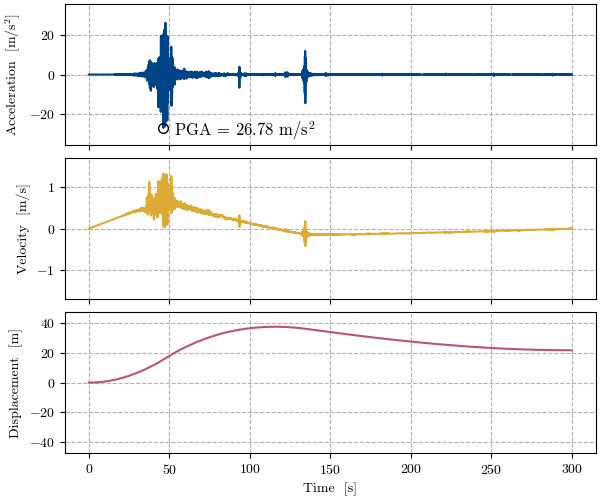

In [8]:
fig = plot_time_series(gm)

## Baseline correction

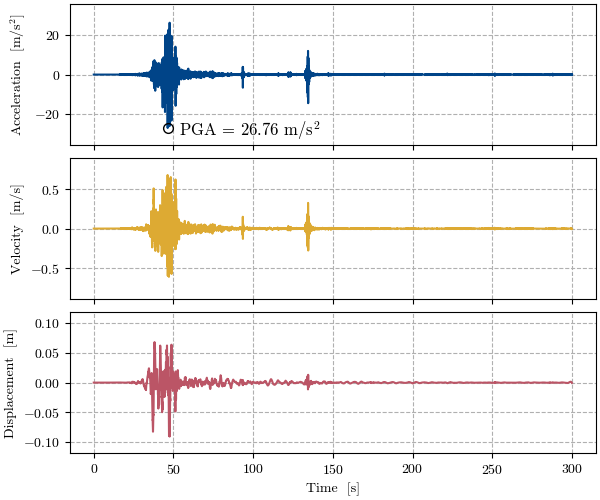

In [9]:
gm_corr = gm.baseline_correct()
fig = plot_time_series(gm_corr)

## Arias intensity and Significant duration

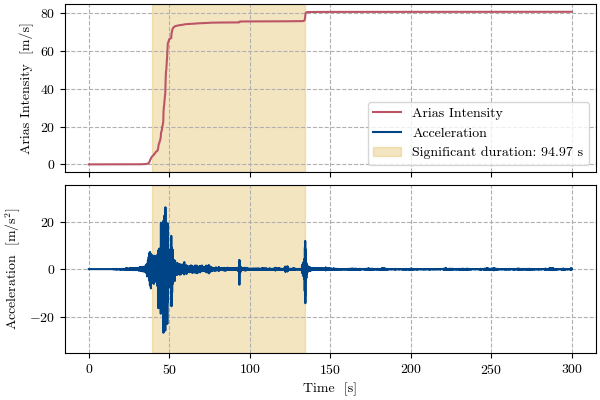

In [10]:
fig = plot_arias_int(gm_corr)

## Fourier Spectrum and Response Spectrum

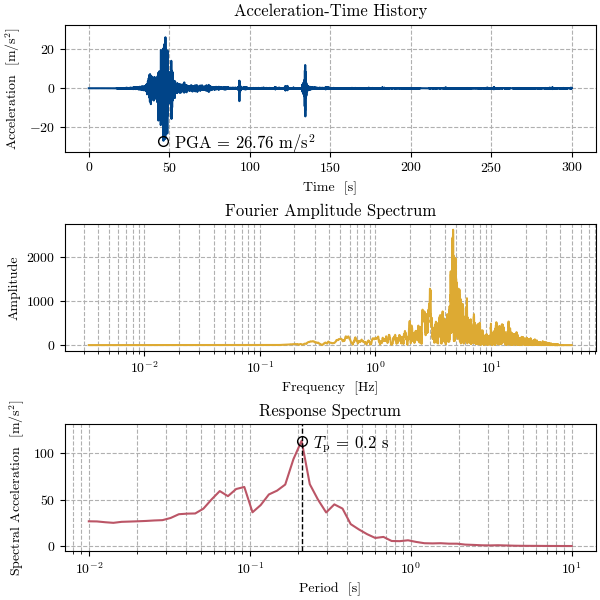

In [11]:
fig = plot_spectra(gm_corr, xlog=True, ylog=False, T_min=0.01, T_max=10, damping=0.05)